### Import

In [1]:
# Import bibliotek
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

In [2]:
# Import danych
feature_num = 20
boston = load_boston()
X = boston.data[:, :feature_num]
y = boston.target
features = boston.feature_names[:feature_num]
pd.DataFrame(X, columns = features).head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


### Przygotowanie danych

Columns:

CRIM: Per capita crime rate by town

ZN: Proportion of residential land zoned for lots over 25,000 sq. ft

INDUS: Proportion of non-retail business acres per town

CHAS : Charles River dummy variable (1 if tract bounds river; 0 otherwise)

NOX: Nitric oxide concentration (parts per 10 million)

RM: Average number of rooms per dwelling

AGE: Proportion of owner-occupied units built prior to 1940

DIS: Weighted distances to five Boston employment centers

RAD: Index of accessibility to radial highways

PTRATIO: Pupil-teacher ratio by town

B: 1000(Bk — 0.63)², where Bk is the proportion of [people of African American descent] by town

LSTAT: Percentage of lower status of the population

MEDV: Median value of owner-occupied homes in $1000s

In [3]:
# Podział danych na treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [4]:
def test(models,  iterations = 1000):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                y, 
                                                                test_size= 0.2)
            r2_test.append(metrics.r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(metrics.r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)

### Regresja Grzbietowa

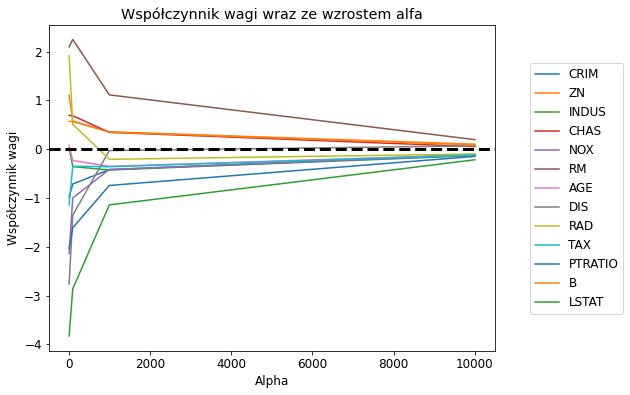

In [5]:
alphas = 10 ** np.arange(1, 5)
ridge_weight = []
for alpha in alphas:    
    ridge = Ridge(alpha = alpha, fit_intercept = True)
    ridge.fit(X_train_std, y_train)
    ridge_weight.append(ridge.coef_)
    
def weight_versus_alpha_plot(weight, alphas, features):
    fig = plt.figure(figsize = (8, 6))
    
    weight = np.array(weight)
    for col in range(weight.shape[1]):
        plt.plot(alphas, weight[:, col], label = features[col])

    plt.axhline(0, color = 'black', linestyle = '--', linewidth = 3)
    
    plt.legend(bbox_to_anchor = (1.3, 0.9))
    plt.title('Współczynnik wagi wraz ze wzrostem alfa')
    plt.ylabel('Współczynnik wagi')
    plt.xlabel('Alpha')
    return fig

plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12


ridge_fig = weight_versus_alpha_plot(ridge_weight, alphas, features)

In [6]:
alpha_range = 10. ** np.arange(-2, 3)
ridge_cv = RidgeCV(alphas = alpha_range, fit_intercept = True)
ridge_cv.fit(X_train_std, y_train)

y_pred = ridge_cv.predict(X_test_std)
print('coefficients:\n', ridge_cv.coef_)
print('best alpha:\n' , ridge_cv.alpha_)
print('\nRSS:', np.sum((y_test - y_pred) ** 2))
print(metrics.r2_score(y_test, y_pred))

coefficients:
 [-1.05933451  1.31050717  0.23022789  0.66955241 -2.45607567  1.99086611
  0.18119169 -3.09919804  2.56480813 -1.71116799 -2.12002592  0.56264409
 -4.00942448]
best alpha:
 1.0

RSS: 2780.645850002648
0.7789704562726552


### Lasso

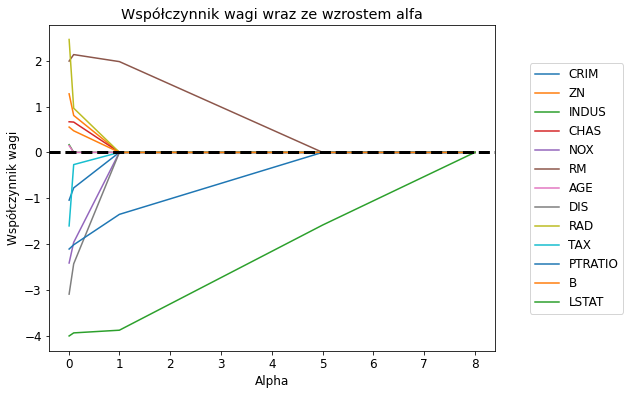

In [7]:
alphas = [0.01, 0.1, 1, 5, 8]

lasso_weight = []
for alpha in alphas:    
    lasso = Lasso(alpha = alpha, fit_intercept = True)
    lasso.fit(X_train_std, y_train)
    lasso_weight.append(lasso.coef_)

lasso_fig = weight_versus_alpha_plot(lasso_weight, alphas, features)

In [8]:
from sklearn.metrics import r2_score

lasso_cv = LassoCV(n_alphas = 10, fit_intercept = True)
lasso_cv.fit(X_train_std, y_train)

y_pred = lasso_cv.predict(X_test_std)
print('coefficients:\n', lasso_cv.coef_)
print('best alpha:\n', lasso_cv.alpha_)
print('\nRSS:', np.sum(( y_test - y_pred ) ** 2))
print(r2_score(y_test, y_pred))

coefficients:
 [-0.98519191  1.15062166  0.          0.67088555 -2.25508394  2.02935132
  0.04844743 -2.99048816  2.0611297  -1.21198616 -2.07289344  0.53270836
 -3.95956239]
best alpha:
 0.030575666002936017

RSS: 2797.2525685618148
0.7776504120728742


### Wynik

In [9]:
ridge_reg = Ridge(alpha=ridge_cv.alpha_)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=lasso_cv.alpha_)
lasso_reg.fit(X_train, y_train)


print('Regresjia ridge: R^2 wynik na danych treningowych', ridge_reg.score(X_train, y_train)*100)
print('Regresjia ridge: R^2 wynik na danych testowych', ridge_reg.score(X_test, y_test)*100, '\n')
print('Regresjia Lasso: R^2 wynik na danych treningowych', lasso_reg.score(X_train, y_train)*100)
print('Regresjia Lasso: R^2 wynik na danych testowych', lasso_reg.score(X_test, y_test)*100)

Regresjia ridge: R^2 wynik na danych treningowych 71.30645548355913
Regresjia ridge: R^2 wynik na danych testowych 78.4777431688241 

Regresjia Lasso: R^2 wynik na danych treningowych 71.26079403488139
Regresjia Lasso: R^2 wynik na danych testowych 78.25793462383346
